# Classification of stable vs. progressive mild cognitive impairment (MCI).

Compare a conventional, domain adversarial, and mixed effects multi-level perceptron/dense neural network (MLP) for the classification of stable vs. progressive MCI from multi-site data. 

Target: progressive MCI is defined as conversion to dementia within 24 months of sample acquisition.

Data: from the ADNIMERGE preprocessed dataset of the ADNI study. This includes demographic, cognitive, genetic, CSF, PET, and structural MRI measurements. The 20 largest sites have been selected and divided into 10x10 nested k-folds (see `create_kfolds.py`). The remaining data has been reserved for evaluation. 

In [1]:
import os
# Suppress unneeded tensorflow log info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from medl.tfutils import set_gpu
from medl.models.mlp_classifiers import BaseMLP, DomainAdversarialMLP, MixedEffectsMLP

from medl.metrics import classification_metrics

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import stats

tf.get_logger().setLevel('ERROR')

Run to select GPU and restrict memory usage to 20%.

In [2]:
set_gpu(1, 0.2)

Load pickled k-folds.

In [3]:
with open('./10x10_kfolds_top20sites.pkl', 'rb') as f:
    kfolds = pickle.load(f)
    
with open('./10x10_kfolds_top20sites_heldout_sites.pkl', 'rb') as f:
    dfXHeldout, dfZHeldout, arrYHeldout = pickle.load(f)

Dataset characteristics.

In [4]:
print(kfolds.x.shape[0], 'subjects')
print(kfolds.x.shape[1], 'features')
print('{:.03f}% converters'.format(kfolds.y.mean() * 100))

392 subjects
37 features
27.041% converters


Define some functions for performing cross-validation and computing feature importance via partial derivatives. 

In [5]:
def get_fold_data(outer_fold, inner_fold=None):
    """Return training and validation data, cluster membership design matrix, and labels 
    for a specified fold. Also return the data for the held-out sites, with the cluster 
    membership design matrix inferred using a random forest trained on the data from 
    seen sites. 

    Args:
        outer_fold (int): Outer fold index.
        inner_fold (int, optional): Inner fold index. Defaults to None.

    Returns:
        (train data, train clusters), train labels, (val data, val clusters), val labels,
            (heldout data, heldout clusters), heldout labels
    """    
    
    dfXTrain, dfZTrain, arrYTrain, dfXVal, dfZVal, arrYVal = kfolds.get_fold(outer_fold, idx_inner=inner_fold)

    scaler = StandardScaler()
    imputer = SimpleImputer()

    arrXTrain = scaler.fit_transform(dfXTrain)
    arrXTrain = imputer.fit_transform(arrXTrain).astype(np.float32)
    arrXVal = scaler.transform(dfXVal)
    arrXVal = imputer.transform(arrXVal).astype(np.float32)
    arrXHeldout = scaler.transform(dfXHeldout)
    arrXHeldout = imputer.transform(arrXHeldout).astype(np.float32)
    
    # Try to infer the design matrix for the heldout sites
    clf = RandomForestClassifier()
    clf.fit(arrXTrain, dfZTrain.idxmax(axis=1))
    arrPredZ = clf.predict(arrXHeldout)
    dfZHeldoutPred = dfZHeldout.copy()
    for i, site in enumerate(arrPredZ):
        dfZHeldoutPred.loc[dfZHeldoutPred.index[i], site] = 1

    return (arrXTrain, dfZTrain.astype(np.float32)), arrYTrain, (arrXVal, dfZVal.astype(np.float32)), arrYVal, \
        (arrXHeldout, dfZHeldoutPred.astype(np.float32)), arrYHeldout
    
def compute_grads(model, inputs):
    """Compute feature gradients/partial derivatives.

    Args:
        model: trained model
        inputs (array or tuple): model inputs

    Returns:
        pd.DataFrame: feature gradients
    """    

    if isinstance(inputs, tuple):
        x, z = inputs
        x = x.mean(axis=0).reshape((1, -1))
        # Use all zero design matrix, since for the ME-MLP we 
        # only want to measure the feature sensitivity of the 
        # fixed effects submodel.
        z = np.zeros((1, z.shape[1]), dtype=np.float32)
        
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            tz = tf.zeros_like(z)
            gt.watch(tx)
            gt.watch(tz)
            ty = model((tx, tz))
            
        dydx = gt.gradient(ty, tx)

    else:
        x = inputs
        x = x.mean(axis=0).reshape((1, -1))
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            gt.watch(tx)
            ty = model(tx)
            
        dydx = gt.gradient(ty, tx)

    dfGrads = pd.DataFrame(np.abs(dydx.numpy()), columns=kfolds.x.columns)
    return pd.melt(dfGrads, var_name='Feature', value_name='Gradient')
    
def compute_random_slope_sd(model):
    """Compute the inter-cluster variances of the ME-MLP's learned random slopes.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: s.d. for each feature
    """    
    arrRandomSlopePosterior = model.randomeffects.re_slope.weights[0].numpy()
    nClusters = kfolds.z.shape[1]
    nFeatures = kfolds.x.shape[1]
    nWeights = nClusters * nFeatures
    arrRandomSlope = arrRandomSlopePosterior[:nWeights]
    arrRandomSlope = arrRandomSlope.reshape((nClusters, nFeatures))

    return pd.DataFrame({'Feature': kfolds.x.columns, 'S.D.': arrRandomSlope.std(axis=0)})
    
def get_random_intercepts(model):
    """Get the learned random intercepts from the trained ME-MLP.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: Site-specific random intercepts
    """    
    arrRandomIntPosterior = model.randomeffects.re_int.weights[0].numpy()
    nClusters = kfolds.z.shape[1]
    arrRandomInt = arrRandomIntPosterior[:nClusters]
    
    return pd.DataFrame({'Site': kfolds.z.columns, 'Random intercept': arrRandomInt})
    
def cross_validate(model_class, outer_fold=None, use_z=False, evaluate_heldout_sites=False, 
                   build_args={}, compile_args={}):
    """Perform cross-validation and compute feature gradients. Specify outer_fold to perform
    cross-validation on one of the inner k-folds (e.g. to tune hyperparameters), otherwise 
    use the outer k-folds for final evaluation. 

    Args:
        model_class: Model class.
        outer_fold (int, optional): Outer fold index. Defaults to None.
        use_z (bool, optional): Model takes design matrix as second input. Defaults to False.
        evaluate_heldout_sites (bool, optional): Evaluate model on held-out sites. Defaults to False.
        build_args (dict, optional): Model constructor arguments. Defaults to {}.
        compile_args (dict, optional): Compilation arguments. Defaults to {}.

    Returns:
        for ME-MLP:
            cross-validated metrics, feature gradients, random slope variances, random intercepts
        for other models:
            cross-validated metrics, feature gradients
    """    
    
    lsResults = []
    lsGrads = []
    if model_class == MixedEffectsMLP:
        lsRandomSlopeSD = [] 
        lsRandomInt = []  
    
    if outer_fold:
        nFolds = kfolds.n_folds
    else:
        nFolds = kfolds.n_folds_inner
    
    for iFold in range(nFolds):
        if outer_fold:
            (xTrain, zTrain), labelTrain, (xVal, zVal), labelVal, \
                (xHeldout, zHeldout), labelHeldout = get_fold_data(outer_fold, iFold)
        else:
            (xTrain, zTrain), labelTrain, (xVal, zVal), labelVal, \
                (xHeldout, zHeldout), labelHeldout = get_fold_data(iFold)
                
        tf.random.set_seed(283)
        model = model_class(**build_args)
        if use_z:
            dataTrain = (xTrain, zTrain)
            dataVal = (xVal, zVal)
            dataHeldout = (xHeldout, zHeldout)
        else:
            dataTrain = xTrain
            dataVal = xVal            
            dataHeldout = xHeldout
            
        model.compile(**compile_args)
        
        dictClassWeights = {0: labelTrain.mean(), 1: (1 - labelTrain.mean())}
        lsCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_auprc', 
                                                        mode='max',
                                                        patience=5, 
                                                        restore_best_weights=True)]

        log = model.fit(dataTrain, labelTrain,
                        validation_data=(dataVal, labelVal),
                        callbacks=lsCallbacks,
                        epochs=50,
                        verbose=0,
                        class_weight=dictClassWeights)
        
        arrPredTrain = model.predict(dataTrain)
        if isinstance(arrPredTrain, tuple):
            arrPredTrain = arrPredTrain[0]
        dictMetrics, youden = classification_metrics(labelTrain, arrPredTrain)
                
        arrPredVal = model.predict(dataVal)
        if isinstance(arrPredVal, tuple):
            arrPredVal = arrPredVal[0]
        dictMetricsVal, _ = classification_metrics(labelVal, arrPredVal, youden)
        for k, v in dictMetricsVal.items():
            dictMetrics['Val_' + k] = v
            
        if evaluate_heldout_sites:
            arrPredHeldout = model.predict(dataHeldout)
            if isinstance(arrPredHeldout, tuple):
                arrPredHeldout = arrPredHeldout[0]
            try:
                dictMetricsHeldout, _ = classification_metrics(labelHeldout, arrPredHeldout, youden)
            except:
                print(arrPredHeldout)
            for k, v in dictMetricsHeldout.items():
                dictMetrics['Heldout_' + k] = v
        
        lsResults += [dictMetrics]
        lsGrads += [compute_grads(model, dataTrain)]
        
        if model_class == MixedEffectsMLP:
            lsRandomSlopeSD += [compute_random_slope_sd(model)]
            lsRandomInt += [get_random_intercepts(model)]
        
    dfResults = pd.DataFrame(lsResults)
    dfGrads = pd.concat(lsGrads, axis=0)
    if model_class == MixedEffectsMLP:
        dfRandomSlopeSD = pd.concat(lsRandomSlopeSD, axis=0)
        dfRandomIntercept = pd.concat(lsRandomInt, axis=0)
        return dfResults, dfGrads, dfRandomSlopeSD, dfRandomIntercept
    else:
        return dfResults, dfGrads
        

## Conventional model

AUROC                     0.884110
Accuracy                  0.847418
Youden's index            0.694835
F1                        0.740064
PPV                       0.638780
NPV                       0.946541
Sensitivity               0.878947
Specificity               0.815175
Val_AUROC                 0.899966
Val_Accuracy              0.820617
Val_Youden's index        0.641234
Val_F1                    0.700993
Val_PPV                   0.589474
Val_NPV                   0.939103
Val_Sensitivity           0.863636
Val_Specificity           0.841749
Heldout_AUROC             0.811803
Heldout_Accuracy          0.751345
Heldout_Youden's index    0.502690
Heldout_F1                0.696747
Heldout_PPV               0.626629
Heldout_NPV               0.844202
Heldout_Sensitivity       0.780488
Heldout_Specificity       0.730392
dtype: float64


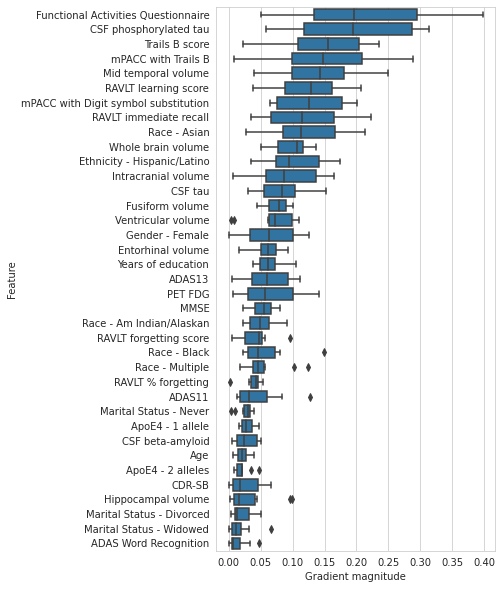

In [6]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.AUC(curve='PR', name='auprc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsBase, dfGradsBase = cross_validate(BaseMLP, evaluate_heldout_sites=True, compile_args=dictCompile)

lsSortOrder = dfGradsBase.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsBase, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax,
            color='C0')
ax.set_xlabel('Gradient magnitude')
print(dfResultsBase.median())

## Domain adversarial model

AUROC                     0.831308
Accuracy                  0.772509
Youden's index            0.545017
F1                        0.643009
PPV                       0.558547
NPV                       0.910552
Sensitivity               0.801261
Specificity               0.787938
Val_AUROC                 0.794984
Val_Accuracy              0.741424
Val_Youden's index        0.482848
Val_F1                    0.603989
Val_PPV                   0.500000
Val_NPV                   0.903890
Val_Sensitivity           0.800000
Val_Specificity           0.758621
Heldout_AUROC             0.742318
Heldout_Accuracy          0.701997
Heldout_Youden's index    0.403993
Heldout_F1                0.645583
Heldout_PPV               0.565509
Heldout_NPV               0.814475
Heldout_Sensitivity       0.747967
Heldout_Specificity       0.700980
dtype: float64


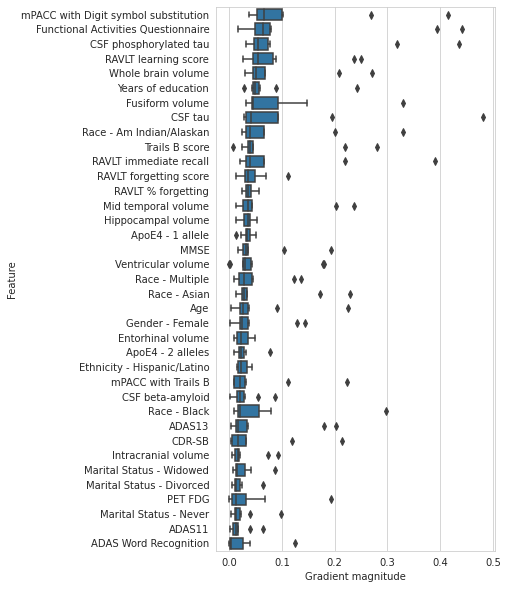

In [7]:
dictBuild = {'n_clusters': kfolds.z.shape[1], 'adversary_layer_units': [8, 8, 4]}
dictCompile = {'loss_gen_weight': 5.0}
dfResultsDA, dfGradsDA = cross_validate(DomainAdversarialMLP, use_z=True, evaluate_heldout_sites=True,
                                        build_args=dictBuild, compile_args=dictCompile)

lsSortOrder = dfGradsDA.groupby('Feature').median().sort_values('Gradient', ascending=False).index
fig, ax = plt.subplots(figsize=(5, 10))
sns.boxplot(data=dfGradsDA, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax, 
            color='C0')
ax.set_xlabel('Gradient magnitude')
print(dfResultsDA.median())

## Mixed effects model

AUROC                     0.950023
Accuracy                  0.885915
Youden's index            0.771829
F1                        0.807844
PPV                       0.736298
NPV                       0.957351
Sensitivity               0.894737
Specificity               0.877666
Val_AUROC                 0.892857
Val_Accuracy              0.790372
Val_Youden's index        0.580743
Val_F1                    0.692654
Val_PPV                   0.615385
Val_NPV                   0.890584
Val_Sensitivity           0.727273
Val_Specificity           0.824507
Heldout_AUROC             0.816077
Heldout_Accuracy          0.742916
Heldout_Youden's index    0.485832
Heldout_F1                0.682355
Heldout_PPV               0.644917
Heldout_NPV               0.815420
Heldout_Sensitivity       0.707317
Heldout_Specificity       0.764706
dtype: float64


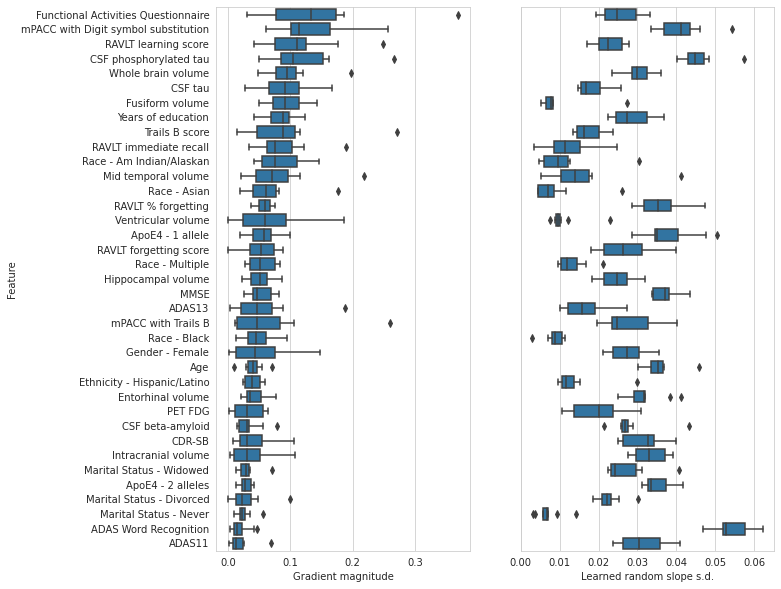

In [8]:
dictBuild = {'n_features': kfolds.x.shape[1],
             'n_clusters': kfolds.z.shape[1],
             'adversary_layer_units': [8, 8, 4],
             'slope_posterior_init_scale': 0.1, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.15, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.001}
dictCompile = {'loss_class_fe_weight': 1.0, 'loss_gen_weight': 5., 'loss_class_me_weight': 1.0}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept = cross_validate(MixedEffectsMLP,  
                                                                            use_z=True, 
                                                                            evaluate_heldout_sites=True,
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
lsSortOrder = dfGradsME.groupby('Feature').median().sort_values('Gradient', ascending=False).index
sns.boxplot(data=dfGradsME, x='Gradient', y='Feature', orient='h', order=lsSortOrder, ax=ax[0], color='C0')
sns.boxplot(data=dfRandomSlopeSD, x='S.D.', y='Feature', orient='h', order=lsSortOrder, ax=ax[1], color='C0')
ax[0].set_xlabel('Gradient magnitude')
ax[1].set_ylabel(None)
ax[1].set_xlabel('Learned random slope s.d.')

print(dfResultsME.median())

### Validation of learned random effects

Start by separating the features into continuous and categorical. 

In [9]:
dfX = kfolds.x
dfZ = kfolds.z

lsContinuous = ['Years of education', 'Age', 'CDR-SB', 'ADAS11', 'ADAS13',
       'ADAS Word Recognition', 'MMSE', 'RAVLT immediate recall',
       'RAVLT learning score', 'RAVLT forgetting score', 'RAVLT % forgetting',
       'Trails B score', 'Functional Activities Questionnaire',
       'mPACC with Digit symbol substitution', 'mPACC with Trails B',
       'Ventricular volume', 'Hippocampal volume', 'Whole brain volume',
       'Entorhinal volume', 'Fusiform volume', 'Mid temporal volume',
       'Intracranial volume', 'PET FDG', 'CSF phosphorylated tau', 'CSF tau',
       'CSF beta-amyloid']

dfContinuous = dfRandomSlopeSD.loc[dfRandomSlopeSD['Feature'].isin(lsContinuous)].copy()
# Compute the median over k-folds
dfContinuous = dfContinuous.groupby('Feature').median()

lsCategorical = ['ApoE4 - 1 allele',
                 'ApoE4 - 2 alleles',
                 'Gender - Female',
                 'Ethnicity - Hispanic/Latino', 
                 'Race - Asian', 
                 'Race - Black', 
                 'Race - Multiple',
                 'Race - Am Indian/Alaskan',
                 'Marital Status - Divorced',
                 'Marital Status - Never', 
                 'Marital Status - Widowed']
                        
dfCategorical = dfRandomSlopeSD.loc[dfRandomSlopeSD['Feature'].isin(lsCategorical)].copy()
# Compute the median over k-folds
dfCategorical = dfCategorical.groupby('Feature').median()

Continuous features:

Compare each random slope $\sigma$ with those found by univariate logistic mixed effects regression models (see `univariate_analyses.ipynb`).

Text(0, 0.5, 'Univariate logisticME random slope s.d.')

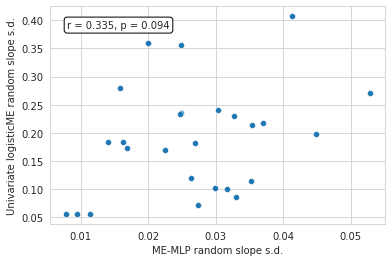

In [10]:
dfDevTest = pd.read_csv('./continuous_univariate_lme.csv', index_col=0)
dfDevTest = dfDevTest.loc[dfContinuous.index]

fig, ax = plt.subplots()
sns.scatterplot(x=dfContinuous['S.D.'], y=dfDevTest['Random slope S.D.'], ax=ax)
r, p = stats.pearsonr(dfContinuous['S.D.'], dfDevTest['Random slope S.D.'])
ax.text(0.05, 0.9, f'r = {r:.03f}, p = {p:.03f}', 
        transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'white', 'edgecolor': 'k'})
ax.set_xlabel('ME-MLP random slope s.d.')
ax.set_ylabel('Univariate logisticME random slope s.d.')

Categorical features:

Correlate each random slope $\sigma$ with the site-stratified relative risk s.d. (see `univariate_analyses.ipynb`).

Text(0, 0.5, 'Relative risk s.d.')

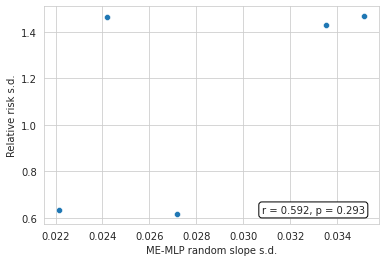

In [18]:
dfRelativeRisk = pd.read_csv('./categorical_relativerisk_sd.csv', index_col=0)

# Relative risk could only be computed for these features due to poor sampling of demographics.
lsVars = ['ApoE4 - 1 allele',
         'ApoE4 - 2 alleles',
         'Gender - Female',
         'Marital Status - Divorced',
         'Marital Status - Widowed']

fig, ax = plt.subplots()
sns.scatterplot(x=dfCategorical['S.D.'].loc[lsVars], y=dfRelativeRisk['Relative Risk'].loc[lsVars], ax=ax)
r, p = stats.pearsonr(dfCategorical['S.D.'].loc[lsVars], dfRelativeRisk['Relative Risk'].loc[lsVars])
ax.text(0.65, 0.05, f'r = {r:.03f}, p = {p:.03f}', 
        transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'white', 'edgecolor': 'k'})
ax.set_xlabel('ME-MLP random slope s.d.')
ax.set_ylabel('Relative risk s.d.')

Compare each site's learned random intercept with its proportion of progressive MCI patients. These should be highly correlated.

Text(0, 0.5, 'Site conversion %')

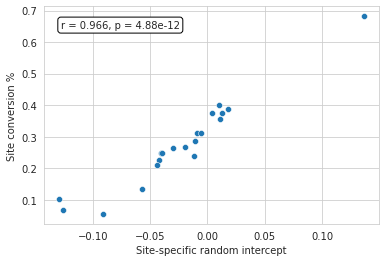

In [12]:
# Compute conversion % by site
dfConversion = kfolds.z.idxmax(axis=1).to_frame('Site')
dfConversion['Conversion'] = kfolds.y
dfSiteConversion = dfConversion.groupby('Site').mean()
dfSiteConversion.columns = ['Conversion %']

dfSiteInt = dfSiteConversion.join(dfRandomIntercept.groupby('Site').median())

fig, ax = plt.subplots()
sns.scatterplot(data=dfSiteInt, x='Random intercept', y='Conversion %', ax=ax)

r, p = stats.pearsonr(dfSiteInt['Random intercept'], dfSiteInt['Conversion %'])
ax.text(0.05, 0.9, f'r = {r:.03f}, p = {p:.2e}', 
        transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'white', 'edgecolor': 'k'})

ax.set_xlabel('Site-specific random intercept')
ax.set_ylabel('Site % pMCI')

Box plot of model performance, showing the distribution over k-folds.

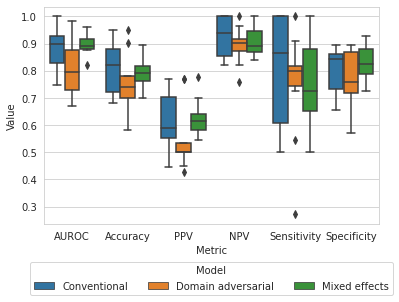

In [13]:
lsPerformance = []
for strModel, df in {'Conventional': dfResultsBase,
                     'Domain adversarial': dfResultsDA,
                     'Mixed effects': dfResultsME}.items():
    dfLong = pd.melt(df, var_name='Metric', value_name='Value')
    dfLong['Model'] = strModel
    lsPerformance += [dfLong]
    
dfPerformance = pd.concat(lsPerformance, axis=0)
sns.boxplot(data=dfPerformance, x='Metric',  y='Value', hue='Model',
            order=['Val_AUROC', 'Val_Accuracy', 'Val_PPV', 'Val_NPV', 'Val_Sensitivity', 'Val_Specificity'])
plt.gca().set_xticklabels(['AUROC', 'Accuracy', 'PPV', 'NPV', 'Sensitivity', 'Specificity'])
plt.gca().legend(bbox_to_anchor=(0.5, -0.25), loc='center', ncol=3, title='Model')